In [1]:
import os, shutil
import zipfile
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConvolution2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adestika","key":"7589383ff79852b38a6c4900fd5d2dae"}'}

In [17]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data


Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
potato-plant-diseases-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!potato-plant-diseases-data.zip

/bin/bash: line 1: potato-plant-diseases-data.zip: command not found


In [19]:
import zipfile
import os

zip_path = "potato-plant-diseases-data.zip"  # Sesuaikan dengan lokasi file jika perlu
extract_path = "potato-plant-diseases-data"

# Ekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil diekstrak ke:", extract_path)


File berhasil diekstrak ke: potato-plant-diseases-data


In [23]:
data_dir = "/content/potato-plant-diseases-data/PotatoPlants"
categories = ["Potato___Early_blight", "Potato___Late_blight","Potato___healthy"]

# Mengecek jumlah gambar per kategori
def count_images(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

data_info = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)
    data_info[category] = count_images(folder_path)

In [24]:
print("Jumlah gambar per kategori:", data_info)

Jumlah gambar per kategori: {'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152}


In [29]:
# Define directories
data_dir = '/content/potato-plant-diseases-data/PlantVillage/PlantVillage'
test_dir = '/content/potato-plant-diseases-data/PotatoPlants'

# Check if directories exist
print("Training directory exists:", os.path.exists(data_dir))
print("Testing directory exists:", os.path.exists(test_dir))

Training directory exists: True
Testing directory exists: True


In [61]:
# Parameters
batch_size = 32
target_size = (224, 224) # Match target size with DenseNet input size
epochs = 20
learning_rate = 1e-4

# Data augmentation hanya untuk Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% data training akan digunakan sebagai validation set
)

# Data testing hanya rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


In [55]:
# Load Training Set (80% dari dataset)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size, # Use target_size variable here
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Ambil bagian untuk training
)

# Load Validation Set (20% dari dataset)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size, # Use target_size variable here
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Ambil bagian untuk validasi
)

# Load Testing Set (Dataset terpisah)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size, # Use target_size variable here
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Found 2152 images belonging to 3 classes.


In [35]:
print("Jumlah gambar pada Training Set:", train_generator.samples)
print("Jumlah gambar pada Validation Set:", val_generator.samples)
print("Jumlah gambar pada Testing Set:", test_generator.samples)


Jumlah gambar pada Training Set: 1722
Jumlah gambar pada Validation Set: 430
Jumlah gambar pada Testing Set: 2152


In [32]:
# Print kategori label dataset
print(train_generator.class_indices)


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


In [56]:
# Custom progress bar callback
class CustomProgressBar(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        print(f" - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [57]:
def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Flatten(),
        Dense(264, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(3, activation='softmax')
    ])

    return model




In [58]:
learning_rate = 1e-4
model = create_densenet_model()
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 264)                 │      13,246,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 264)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 264)                 │           1,056 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          33,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,332,523 (77.56 MB)

 Trainable params: 13,292,059 (50.71 MB)

 Non-trainable params: 7,040,464 (26.86 MB)

In [63]:
progress_bar = CustomProgressBar()
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[progress_bar]
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8066 - loss: 0.4916Epoch 1/20
 - loss: 0.4734 - accuracy: 0.8200 - val_loss: 0.2428 - val_accuracy: 0.9674
54/54 ━━━━━━━━━━━━━━━━━━━━ 459s 9s/step - accuracy: 0.8069 - loss: 0.4913 - val_accuracy: 0.9674 - val_loss: 0.2428
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8378 - loss: 0.4331Epoch 2/20
 - loss: 0.4462 - accuracy: 0.8322 - val_loss: 0.2182 - val_accuracy: 0.9535
54/54 ━━━━━━━━━━━━━━━━━━━━ 458s 9s/step - accuracy: 0.8377 - loss: 0.4333 - val_accuracy: 0.9535 - val_loss: 0.2182
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8473 - loss: 0.4209Epoch 3/20
 - loss: 0.4209 - accuracy: 0.8374 - val_loss: 0.1939 - val_accuracy: 0.9674
54/54 ━━━━━━━━━━━━━━━━━━━━ 463s 9s/step - accuracy: 0.8471 - loss: 0.4209 - val_accuracy: 0.9674 - val_loss: 0.1939
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8541 - loss: 0.3902Epoch 4/20
 - loss: 0.3802 - accuracy: 0.8653 - val_loss: 0.

In [64]:
# Evaluasi model dengan test set
test_loss, test_acc = model.evaluate(test_generator)

# Menampilkan hasil evaluasi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


68/68 ━━━━━━━━━━━━━━━━━━━━ 448s 7s/step - accuracy: 0.9905 - loss: 0.0573
Test Loss: 0.0534
Test Accuracy: 0.9870


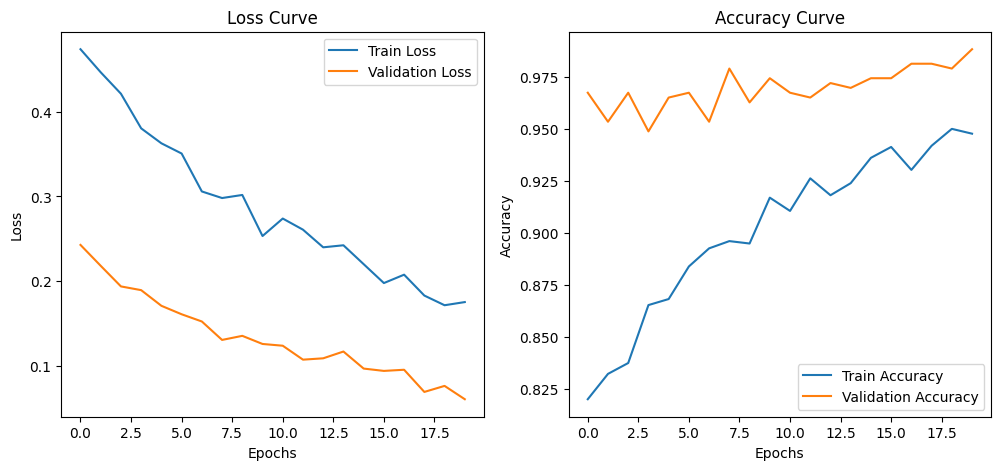

In [65]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [68]:

# Menyimpan model dalam format SavedModel
model.export('model_saved')
print("Model disimpan dalam format SavedModel")


Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_901')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134236015923984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004769552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004770128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236015924752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236015924560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004771088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004771472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004769360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004770704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004773008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134236004773392

In [69]:
# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('model_saved')
tflite_model = converter.convert()

# Simpan model TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model dikonversi dan disimpan dalam format TFLite")


Model dikonversi dan disimpan dalam format TFLite


In [75]:
# Pastikan TensorFlow.js sudah terinstall
!pip install tensorflowjs

# Import library TensorFlow.js
import tensorflowjs as tfjs

import shutil

# Hapus folder lama jika ada
shutil.rmtree("tfjs_model", ignore_errors=True)
print("Folder tfjs_model lama dihapus.")


Folder tfjs_model lama dihapus.


In [76]:

# Pastikan model sudah dimuat sebelumnya
model_path = "model_saved"  # Path model Anda
output_path = "tfjs_model"   # Folder output untuk model TFJS

# Konversi model ke TensorFlow.js
tfjs.converters.convert_tf_saved_model(
    model_path,
    output_path,
    weight_shard_size_bytes=2147483648  # Set agar hanya menghasilkan 1 file bin
)

print("Model berhasil dikonversi ke format TensorFlow.js.")


Model berhasil dikonversi ke format TensorFlow.js.


In [77]:
import os

# Cek isi folder hasil konversi
files = os.listdir("tfjs_model")
print("Isi folder tfjs_model:", files)


Isi folder tfjs_model: ['group1-shard1of1.bin', 'model.json']


In [71]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.12
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.17.0.34.13
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.37.0
bigquery-magics==0.6.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.1.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4

In [72]:
!pip freeze > requirements.txt
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
import os

# Pilih salah satu dataset utama (PlantVillage atau PotatoPlants)
dataset_path = "potato-plant-diseases-data/PlantVillage/PlantVillage"

# Ambil nama folder sebagai label kelas
class_labels = sorted(os.listdir(dataset_path))  # Urutkan agar konsisten

# Simpan ke file labels.txt
with open("labels.txt", "w") as f:
    for label in class_labels:
        f.write(f"{label}\n")

print("Label kelas berhasil disimpan di 'labels.txt':", class_labels)

Label kelas berhasil disimpan di 'labels.txt': ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [74]:
with open("labels.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

print("Label yang dimuat:", labels)

Label yang dimuat: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
